# <font color='violet'>Feature Engineering<font>

In the previous notebook, I ended up with a dataframe with all necessary rows and clean columns: https://github.com/fractaldatalearning/Capstone2/blob/main/notebooks/preprocessing1b_get_usable_df.ipynb

Here, I'll create a column that indicates how many times any given item has been ordered by a user in the past. Then use that to calculate the percentage of past orders where a user has purchased any given item. 

My intuition is that cross-row calculations don't count as leakage and negatively impact modeling IF I'm adding data that has exclusively to do with past orders. If this logic turns out to be inappropriate, I can just exclude these columns in modeling. 

Once that row has been completed, I'll engineer columns for product keywords and do any other feature engineering that seems meaningful prior to encoding and standardization that is better done as part of a modeling pipeline. 

In [ ]:
import pandas as pd
import numpy as np
import os
from library.sb_utils import save_file

import random
import collections

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.lines as mlines

from IPython.display import Audio
sound_file = './alert.wav'

In [2]:
df = pd.read_csv('../data/processed/users_all_rows_clean.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2174119 entries, 0 to 2174118
Data columns (total 11 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   order_by_user_sequence  int64  
 3   order_dow               int64  
 4   order_hour_of_day       int64  
 5   days_since_prior_order  float64
 6   add_to_cart_sequence    int64  
 7   reordered               int64  
 8   product_name            object 
 9   aisle_name              object 
 10  dept_name               object 
dtypes: float64(1), int64(7), object(3)
memory usage: 182.5+ MB


**<font color='violet'>Group the dataframe and get a cumulative sum of purchases per product per user</font>**

In [3]:
# In order to get a cumsum of purchases, I'll need a 'purchased' column

df['purchased'] = 0
df['purchased'] = df[df['add_to_cart_sequence']>0]['purchased'].replace(0,1)
df['purchased'] = df['purchased'].fillna(0)

df['purchased'].value_counts()

0.0    1840246
1.0     333873
Name: purchased, dtype: int64

In [4]:
relevant_cols = df.loc[:,['user_id', 'order_by_user_sequence', 'purchased', 'product_name']]
grouped_df = relevant_cols.groupby(['user_id', 'product_name', 
                                    'order_by_user_sequence']).sum().groupby(
    level=[0,1]).cumsum().reset_index()
grouped_df[grouped_df['purchased']>1].head()

,user_id,product_name,order_by_user_sequence,purchased
45,75,All Natural Original Hummus,21,2.0
46,75,All Natural Original Hummus,22,2.0
47,75,All Natural Original Hummus,23,2.0
58,75,Asparation/Broccolini/Baby Broccoli,11,2.0
59,75,Asparation/Broccolini/Baby Broccoli,12,3.0


In [5]:
# Check out values of 'purchased' column for one user's purchases of one item.

grouped_df[grouped_df['product_name']=='All Natural Original Hummus']

,user_id,product_name,order_by_user_sequence,purchased
31,75,All Natural Original Hummus,7,1.0
32,75,All Natural Original Hummus,8,1.0
33,75,All Natural Original Hummus,9,1.0
34,75,All Natural Original Hummus,10,1.0
35,75,All Natural Original Hummus,11,1.0
36,75,All Natural Original Hummus,12,1.0
37,75,All Natural Original Hummus,13,1.0
38,75,All Natural Original Hummus,14,1.0
39,75,All Natural Original Hummus,15,1.0
40,75,All Natural Original Hummus,16,1.0


In [6]:
df = df.merge(grouped_df, on=['user_id', 'product_name', 'order_by_user_sequence'])
df.head(2)

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_sequence,reordered,product_name,aisle_name,dept_name,purchased_x,purchased_y
0,2108915,288,1,0,14,-1.0,1,0,Organic Avocado,fresh fruits,produce,1.0,1.0
1,2108915,288,1,0,14,-1.0,2,0,Organic Baby Arugula,packaged vegetables fruits,produce,1.0,1.0


In [7]:
df[(df['user_id']==75)&(df['product_name']=='All Natural Original Hummus')]

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_sequence,reordered,product_name,aisle_name,dept_name,purchased_x,purchased_y
1295527,2123286,75,7,0,14,6.0,10,0,All Natural Original Hummus,fresh dips tapenades,deli,1.0,1.0
1295727,3192011,75,21,0,13,22.0,7,1,All Natural Original Hummus,fresh dips tapenades,deli,1.0,2.0
1608947,690372,75,8,5,15,5.0,0,0,All Natural Original Hummus,fresh dips tapenades,deli,0.0,1.0
1608985,64791,75,9,2,13,11.0,0,0,All Natural Original Hummus,fresh dips tapenades,deli,0.0,1.0
1609030,1047678,75,10,5,12,3.0,0,0,All Natural Original Hummus,fresh dips tapenades,deli,0.0,1.0
1609083,44604,75,11,4,11,6.0,0,0,All Natural Original Hummus,fresh dips tapenades,deli,0.0,1.0
1609152,20042,75,12,3,12,6.0,0,0,All Natural Original Hummus,fresh dips tapenades,deli,0.0,1.0
1609211,1354911,75,13,1,13,5.0,0,0,All Natural Original Hummus,fresh dips tapenades,deli,0.0,1.0
1609265,2391532,75,14,1,12,7.0,0,0,All Natural Original Hummus,fresh dips tapenades,deli,0.0,1.0
1609327,2641583,75,15,0,13,6.0,0,0,All Natural Original Hummus,fresh dips tapenades,deli,0.0,1.0


In [8]:
# The merge succeeded. Work with purchased_y column to make sure it only shows past purchases.
df.loc[df['add_to_cart_sequence']>0, 'purchased_y'] -= 1
df[(df['user_id']==75)&(df['product_name']=='All Natural Original Hummus')]

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_sequence,reordered,product_name,aisle_name,dept_name,purchased_x,purchased_y
1295527,2123286,75,7,0,14,6.0,10,0,All Natural Original Hummus,fresh dips tapenades,deli,1.0,0.0
1295727,3192011,75,21,0,13,22.0,7,1,All Natural Original Hummus,fresh dips tapenades,deli,1.0,1.0
1608947,690372,75,8,5,15,5.0,0,0,All Natural Original Hummus,fresh dips tapenades,deli,0.0,1.0
1608985,64791,75,9,2,13,11.0,0,0,All Natural Original Hummus,fresh dips tapenades,deli,0.0,1.0
1609030,1047678,75,10,5,12,3.0,0,0,All Natural Original Hummus,fresh dips tapenades,deli,0.0,1.0
1609083,44604,75,11,4,11,6.0,0,0,All Natural Original Hummus,fresh dips tapenades,deli,0.0,1.0
1609152,20042,75,12,3,12,6.0,0,0,All Natural Original Hummus,fresh dips tapenades,deli,0.0,1.0
1609211,1354911,75,13,1,13,5.0,0,0,All Natural Original Hummus,fresh dips tapenades,deli,0.0,1.0
1609265,2391532,75,14,1,12,7.0,0,0,All Natural Original Hummus,fresh dips tapenades,deli,0.0,1.0
1609327,2641583,75,15,0,13,6.0,0,0,All Natural Original Hummus,fresh dips tapenades,deli,0.0,1.0


In [9]:
# The purchases_y column now contains the values I want. Clean this up.
df = df.drop(columns='purchased_x')
df = df.rename(columns={'purchased_y':'prior_purchases'})
df['prior_purchases'] = df['prior_purchases'].astype('int')
df.head(2)

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_sequence,reordered,product_name,aisle_name,dept_name,prior_purchases
0,2108915,288,1,0,14,-1.0,1,0,Organic Avocado,fresh fruits,produce,0
1,2108915,288,1,0,14,-1.0,2,0,Organic Baby Arugula,packaged vegetables fruits,produce,0


**<font color='violet'>Beyond a count of how many times a user has purchased an item in teh past: In what portion of past orders has a user purchased an item?</font>**

In [10]:
# Create the column
df['purchased_percent_prior'] = df['prior_purchases'] / df['order_by_user_sequence']
df['purchased_percent_prior'].value_counts()

0.000000    137210
0.200000     55854
0.250000     55582
0.166667     54313
0.142857     52371
             ...  
0.393258         1
0.460674         1
0.847458         1
0.465909         1
0.402778         1
Name: purchased_percent_prior, Length: 2422, dtype: int64

In [11]:
df.sample(15)

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_sequence,reordered,product_name,aisle_name,dept_name,prior_purchases,purchased_percent_prior
1002650,2304803,205671,24,6,19,3.0,0,0,100% Whole Wheat Fusilli No. 34,dry pasta,dry goods pasta,5,0.208333
1067079,3401066,33344,8,6,18,2.0,0,0,Bun Size Franks made with Pork & Chicken,hot dogs bacon sausage,meat seafood,1,0.125000
1325036,2441556,99992,3,6,14,30.0,2,0,Vanilla Raspberry Swirl Frozen Yogurt,ice cream ice,frozen,0,0.000000
1105112,585810,56480,6,4,23,11.0,0,0,Mediterranean Style Medleys Dog Food,dog food care,pets,3,0.500000
1629618,2123707,145922,26,6,14,8.0,0,0,"Organic Tomato Paste, No Salt Added",canned jarred vegetables,canned goods,3,0.115385
687565,1798594,33779,39,3,21,6.0,0,0,Wicked Fresh! Mouthwash - Cool Mountain Mint,oral hygiene,personal care,1,0.025641
1312761,484595,63164,6,0,10,8.0,7,1,Pico De Gallo Chunky Salsa,fresh dips tapenades,deli,1,0.166667
1987045,376332,164428,3,0,14,12.0,0,0,Mild Organic Salsa,fresh dips tapenades,deli,1,0.333333
59946,851153,194615,2,4,8,22.0,6,0,Organic Turkey Hot Dogs,hot dogs bacon sausage,meat seafood,0,0.000000
1499233,685621,118088,11,0,16,5.0,0,0,Classic Chevre Crumbled Goat Cheese,packaged cheese,dairy eggs,1,0.090909


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2174119 entries, 0 to 2174118
Data columns (total 13 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   order_id                 int64  
 1   user_id                  int64  
 2   order_by_user_sequence   int64  
 3   order_dow                int64  
 4   order_hour_of_day        int64  
 5   days_since_prior_order   float64
 6   add_to_cart_sequence     int64  
 7   reordered                int64  
 8   product_name             object 
 9   aisle_name               object 
 10  dept_name                object 
 11  prior_purchases          int64  
 12  purchased_percent_prior  float64
dtypes: float64(2), int64(8), object(3)
memory usage: 232.2+ MB


In [13]:
df.describe()

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_sequence,reordered,prior_purchases,purchased_percent_prior
count,2.174119e+06,2.174119e+06,2.174119e+06,2.174119e+06,2.174119e+06,2.174119e+06,2.174119e+06,2.174119e+06,2.174119e+06,2.174119e+06
mean,1.714335e+06,1.007551e+05,2.857891e+01,2.767469e+00,1.340722e+01,8.855513e+00,1.278327e+00,9.045641e-02,2.444300e+00,1.233999e-01
std,9.889512e+05,5.953240e+04,2.179073e+01,2.059496e+00,4.269585e+00,8.047374e+00,4.132511e+00,2.868346e-01,3.637663e+00,1.452078e-01
min,2.140000e+02,7.500000e+01,1.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.585620e+05,4.918700e+04,1.100000e+01,1.000000e+00,1.000000e+01,3.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.030303e-02
50%,1.721186e+06,9.830700e+04,2.300000e+01,3.000000e+00,1.300000e+01,6.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,6.896552e-02
75%,2.562645e+06,1.530290e+05,4.100000e+01,5.000000e+00,1.600000e+01,1.100000e+01,0.000000e+00,0.000000e+00,2.000000e+00,1.600000e-01
max,3.420932e+06,2.058220e+05,1.000000e+02,6.000000e+00,2.300000e+01,3.000000e+01,8.200000e+01,1.000000e+00,7.900000e+01,9.782609e-01


This dataset now has all the necessary rows and columns in order to use it for making predictions. Every order by ever user contains a row for every item they have ever purchased, and the prior_purchases column contains the number of times a user has bought any given item *in the past*. This could be ready for encoding and modeling. 

First, though, I'll do some feature engineering with the product names to pull out potential keywords that could improve model performance. 

**<font color='violet'>Engineer columns for product keywords.</font>**

In [14]:
# Start with getting words that appear in product names but aren't already covered 
# by aisle and department classifications. 

all_prod_words = set(df['product_name'].tolist())
all_prod_words = [i.split() for i in all_prod_words]
all_prod_words = [i for sublist in all_prod_words for i in sublist]

aisle_words = set(df['aisle_name'].tolist())
aisle_words = [i.split() for i in aisle_words]
aisle_words = [i for sublist in aisle_words for i in sublist]
aisle_words = list(set(aisle_words))

dept_words = set(df['dept_name'].tolist())
dept_words = [i.split() for i in dept_words]
dept_words = [i for sublist in dept_words for i in sublist]
dept_words = list(set(dept_words))

all_prod_unique_words = [word for word in all_prod_words if word not in aisle_words]
all_prod_unique_words = [word for word in all_prod_words if word not in dept_words]

counts = collections.Counter(all_prod_words)
counts.most_common(60)

[('Organic', 2851),
 ('&', 1996),
 ('Chocolate', 1096),
 ('Cheese', 979),
 ('Free', 884),
 ('Original', 709),
 ('Chicken', 655),
 ('Yogurt', 597),
 ('Cream', 591),
 ('Whole', 591),
 ('Milk', 573),
 ('with', 532),
 ('Sauce', 516),
 ('Rice', 502),
 ('Butter', 490),
 ('Natural', 489),
 ('Vanilla', 481),
 ('White', 459),
 ('Mix', 430),
 ('Tea', 424),
 ('Bar', 415),
 ('Fruit', 407),
 ('Gluten', 401),
 ('Juice', 397),
 ('Chips', 371),
 ('Sweet', 370),
 ('Dark', 369),
 ('Coconut', 364),
 ('Cheddar', 349),
 ('Oil', 334),
 ('Bread', 328),
 ('and', 326),
 ('100%', 325),
 ('Ice', 325),
 ('Almond', 318),
 ('Green', 317),
 ('Salt', 316),
 ('Fat', 315),
 ('Strawberry', 314),
 ('Water', 306),
 ('Apple', 306),
 ('Baby', 306),
 ('Fresh', 304),
 ('Coffee', 303),
 ('Grain', 296),
 ('With', 295),
 ('Food', 291),
 ('Style', 287),
 ('Roasted', 286),
 ('Lemon', 285),
 ('Red', 279),
 ('Black', 278),
 ('Pasta', 278),
 ('Honey', 277),
 ('Peanut', 271),
 ('Soup', 269),
 ('Classic', 257),
 ('Potato', 257),
 ('Bro

Now, if high-frequency words appear in products across many different departments, it could  sense to give them their own column. Explore words with counts over 300. "Fresh" seems like a meaningful feature, but none of the words that appear under 300 times seem to be as meaningul as product types. Do remove obviously useless words like '&'.

In [15]:
potential_keywords = ['Organic','Chocolate','Cheese','Free','Original','Chicken','Yogurt',
                      'Cream','Whole','Milk','Sauce','Rice','Butter','Natural','Vanilla',
                      'White','Mix','Tea','Bar','Fruit','Gluten','Juice','Chips','Sweet','Dark',
                      'Coconut','Cheddar','Oil','Bread','Ice','Almond','Green','Salt','Fat',
                      'Strawberry','Apple','Water','Baby','Fresh','Coffee']

potential_keywords.sort()

for k in potential_keywords:
    print(k, ': ', len(df[df['product_name'].str.contains(k)]['dept_name'].unique()))

Almond :  13
Apple :  18
Baby :  15
Bar :  19
Bread :  11
Butter :  16
Cheddar :  14
Cheese :  17
Chicken :  13
Chips :  8
Chocolate :  13
Coconut :  17
Coffee :  10
Cream :  19
Dark :  15
Fat :  13
Free :  19
Fresh :  18
Fruit :  17
Gluten :  14
Green :  19
Ice :  13
Juice :  13
Milk :  12
Mix :  18
Natural :  19
Oil :  14
Organic :  20
Original :  20
Rice :  16
Salt :  14
Sauce :  14
Strawberry :  13
Sweet :  19
Tea :  13
Vanilla :  15
Water :  13
White :  20
Whole :  17
Yogurt :  11


To me, it would make sense to put the cutoff at words that appear across more than 17 departments: Apple, Bar, Cream, Free, Fresh, Green, Mix, Natural, Organic, Original, Sweet, White. Keywords that appear across 16-17 departments are butter, cheese, coconut, fruit, rice, and whole. None of these except maybe "whole" seem as meaningful as organic, fresh, or white. 

In [16]:
# Start a column for each keyword.

keywords = ['apple', 'bar', 'cream', 'free', 'fresh', 'green', 'mix', 'natural', 'organic', 
            'original', 'sweet', 'white']

df[keywords] = 0
df.columns

Index(['order_id', 'user_id', 'order_by_user_sequence', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order', 'add_to_cart_sequence',
       'reordered', 'product_name', 'aisle_name', 'dept_name',
       'prior_purchases', 'purchased_percent_prior', 'apple', 'bar', 'cream',
       'free', 'fresh', 'green', 'mix', 'natural', 'organic', 'original',
       'sweet', 'white'],
      dtype='object')

In [17]:
# Fill each column with a 1 where the word appears in the product name.

for k in keywords:
    df[k] = df[k].mask(df['product_name'].str.contains(k.title()), 1)

df['organic'].value_counts()

0    1479745
1     694374
Name: organic, dtype: int64

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2174119 entries, 0 to 2174118
Data columns (total 25 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   order_id                 int64  
 1   user_id                  int64  
 2   order_by_user_sequence   int64  
 3   order_dow                int64  
 4   order_hour_of_day        int64  
 5   days_since_prior_order   float64
 6   add_to_cart_sequence     int64  
 7   reordered                int64  
 8   product_name             object 
 9   aisle_name               object 
 10  dept_name                object 
 11  prior_purchases          int64  
 12  purchased_percent_prior  float64
 13  apple                    int64  
 14  bar                      int64  
 15  cream                    int64  
 16  free                     int64  
 17  fresh                    int64  
 18  green                    int64  
 19  mix                      int64  
 20  natural                  int64  
 21  organic 

**<font color='violet'>Deal with 'missing' department</font>**

Product keyword columns got created successfully. Now, Look into departments to see which products belong to 'missing' and 'other' columns. Consider if reclassification makes sense.

In [19]:
print(len(df[df['dept_name']=='missing']['product_name'].unique()))
print(len(df[df['dept_name']=='other']['product_name'].unique()))

231
138


Most products seem like they could actually be reclassified easily into another existing category. With over 350 products, though, it would impractical to re-categorize them all myself. Plus, while I can easily guess some products' aisles and departments, if I don't know whether peanuts, for example, are in tiny bags or bulk, I could just muddy other departments and whatever intrinsic 'reorder-ability' they come with. 

Therefore, I will keep this data as-is, at least for now. I can try when doing initial modeling to see if models perform  better when actually removing rows where department=missing. It is common practice to remove nan rows, and 'missing' is fundamentally the same as nan. This would lead to an inability to predict whether items from that department are reordered, but it could improve predictive abilities of the model as a whole by leaving the model with a more coherent "department" category as a feature. 

**<font color='violet'>Visualize new column</font>**

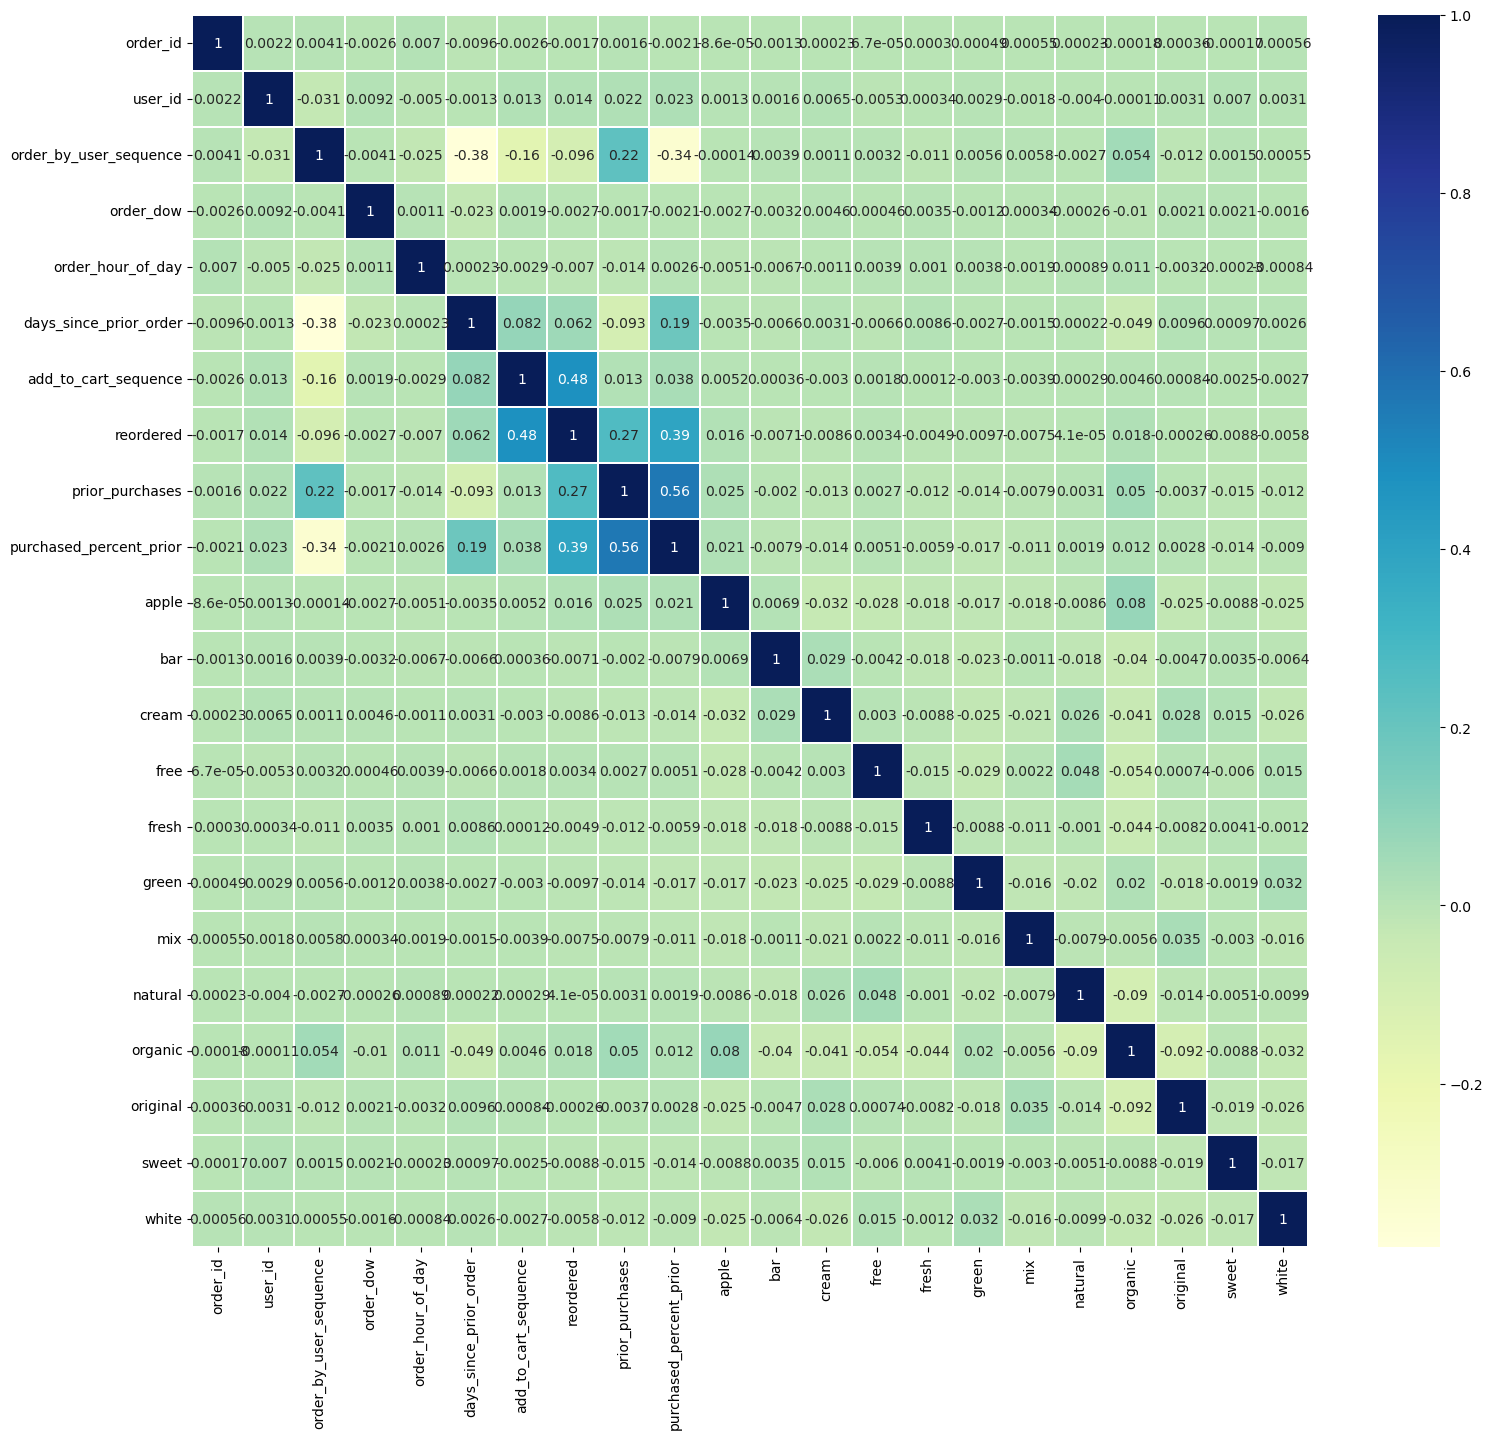

In [20]:
# Do any of these new columns have a higher correlation to the target variable than columns 
# did in the past?
plt.figure(figsize=(18,16))
sns.heatmap(df.corr(), linewidths=.1, cmap="YlGnBu", annot=True)
plt.yticks(rotation=0);

Predictably, the prior_puchases column has a higher correlation with 'reordered' than any previously-existing. The purchased_percent_prior has an even higher correlation, almost as high as 'add_to_cart_sequence,' which is actually another dependent variable and closely predictive of reorders given that 100% of reorders occur where add_to_cart_sequence>0. So purchased_percent_prior, despite not leaking data about the current order's actual target variable, is a strong predictor and will be very useful in modeling. 

Do some further visualization with the purchased_percent_prior column and "reordered." 

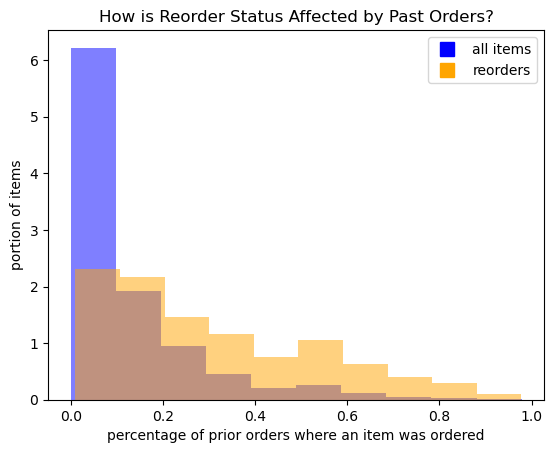

In [21]:
# Separate out reorders and non-reorders, then plot each as a histogram
reorders = df.loc[df['reordered']==1,:].copy()

plt.hist(df['purchased_percent_prior'], color='blue', density=True, alpha=0.5, bins=10)
plt.hist(reorders['purchased_percent_prior'], color='orange', density=True, alpha=0.5, bins=10)
plt.title('How is Reorder Status Affected by Past Orders?')
plt.xlabel('percentage of prior orders where an item was ordered')
plt.ylabel('portion of items')
blue = mlines.Line2D([], [], color='blue', marker='s', linestyle='None', markersize=10, 
                       label='all items')
orange = mlines.Line2D([], [], color='orange', marker='s', linestyle='None', markersize=10, 
                       label='reorders')
plt.legend(handles=[blue, orange]);

**<font color='violet'>Conclusions and Next Steps</font>**

Relative to all items, reorders of products are much more likely to occur when they've been ordered in at least 10% of previous orders. 

Can't do the rest of the encoding or normalization until I have a train/test split and pipeline for it. Save work done so far as new csv file and pick up in next notebook preprocessing3: https://github.com/fractaldatalearning/Capstone2/blob/main/notebooks/preprocessing3_encoding.ipynb

In [22]:
features_engineered = df
datapath = '../data/processed'
save_file(features_engineered, 'features_engineered.csv', datapath)

A file already exists with this name.

Do you want to overwrite? (Y/N)Y
Writing file.  "../data/processed/features_engineered.csv"
